# BigMart Sales Mini Project  

![](https://scontent.foua5-1.fna.fbcdn.net/v/t1.6435-9/76903806_2618951018128214_1634804792129748992_n.jpg?_nc_cat=108&ccb=1-7&_nc_sid=e3f864&_nc_ohc=CPwn9wYkDW8AX_eBK-n&_nc_ht=scontent.foua5-1.fna&oh=00_AfDW7IIqs6bTHrU5f5qtrRqy4YOqX4oJujApEt-dnQrIhQ&oe=64F469A5)

# 1) Problem Statement  


The Data Scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim of this data science project is to build a predictive model and find out the sales of each product at a particular store.  

- **Business Goal :** Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

- **Analysis:**
    * **Type of problem:** Supervised Learning problem
    * **Target feature :** Item_Outlet_Sales

We will handle this problem in a structured way following the table of content given below:
1) Problem Statement  
2) Hypothesis Generation  
3) Loading Packages and Data  
4) Data Structure and Content  
5) Exploratory Data Analysis  
6) Univariate Analysis  
7) Bivariate Analysis  
8) Missing Value Treatment  
9) Feature Engineering  
10) Encoding Categorical Variables  
11) Label Encoding  
12) One Hot Encoding  
13) PreProcessing Data  
14) Modeling  
15) Linear Regression  
16) Regularized Linear Regression  
17) RandomForest  
18) XGBoost  
19) Summary  

# 2) Hypothesis Generation

There are four (04) hypothesis that we would want to test after the EDA:

- **On basis of item:**
    1. **Item visibility in store:** The location of product in a store will impact sales. Ones which are right at entrance will catch the eye of customer first rather than the ones in back.
    2. **Product Frequency:** More frequent products will have high Sales.


- **On basis of store:**

    1. **City type:** Stores located in urban cities should have higher sales because of the higher income levels of people there.
    2. **Store capacity:** Stores which are very big in size should have higher sales as they act like one-stop-shops and people would prefer getting everything from one place.

# 3) Loading Packages and Data

In [643]:
import numpy as np # linear algebra
import pandas as pd # data processing
import math
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna

# Ignore warnings ;)
import warnings
warnings.simplefilter("ignore")

import pickle

# set seed for reproductibility
np.random.seed(0)

In [644]:
# loading the data 
train = pd.read_csv("/kaggle/input/bigmart-sales/Train.csv")
test  = pd.read_csv( "/kaggle/input/bigmart-sales/Test.csv")

# 4) Data Structure and Content

In [645]:
# head function will tell the top records in the data set
train.head()   # python shows the top 5 records by default

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [646]:
train.Item_Type.value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [647]:
# shape attribute tells us the number of observations and variables we have in the data set.
train.shape

(8523, 12)

In our dataset there are **8523 different items** with **12 features**.

In [648]:
# info() is used to check the Information about the data and the datatypes of each respective attribute
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


**Features Description:**

* **Numerical features:**
    - **Item_Weight       :** Weight of the product or item.
    - **Item_Visibility   :** The % of the total display area of all products in a store allocated to the particular product.
    - **Item_MRP          :** Maximum Retail Price (list price) of the product
    - **Outlet_Establishment_Year :** The year in which the store was established.
    - **Item_Outlet_Sales :** sales of the product in a particular store. This is the target variable to be predicted.
    

* **Categorical features:**
    - **Item_Identifier :** Unique product ID (we would want to drop this column later) 
    - **Item_Fat_Content :** Whether the product is low, fat or not
    - **Item_Type         :** The category to which the product belongs.
    - **Outlet_Identifier :** Unique store ID
    - **Outlet_Size    :** The size of the store in terms of ground area covered.
    - **Outlet_Location_Type :** The type of city in which the store is located.
    - **Outlet_Type :** Whether the outlet is just a grocery store or some sort of supermarket.

In [649]:
# The describe() method help to see data spread for numerical values by default : min, max, mean, percentiles...
# but we can use the argument include='all' to see the descriptive stats about all types of variables
train.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [650]:
# get the number of missing datapoints per column
train.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We can observe that we are having:
* **2410 missing values in the Outlet_Size feature** which is a categorical feature. 
* **1463 missing values in the Item_Weight feature**


For dealing with missing values, you'll need to use our intuition. Generally to figure out why the values are missing, we can ask ourself:
> Are these values missing because they weren't recorded or because they does't exist?

- **Doesn't exist   :** then we can keep them as NaN or simply drop them.
- **Weren't recorded:** then we can do imputation using different techniques. I'll choose between mean and mode imputation.

In [651]:
# maybe we should consider the 'Outlet_Establishment_Year' column as a categorical column
#train['Outlet_Establishment_Year'].value_counts()
#train['Outlet_Establishment_Year'] = train['Outlet_Establishment_Year'].astype(str)
train.Outlet_Establishment_Year

0       1999
1       2009
2       1999
3       1998
4       1987
        ... 
8518    1987
8519    2002
8520    2004
8521    2009
8522    1997
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

In [652]:
train['Outlet_Establishment_Year'].dtype

dtype('int64')

In [653]:
train['Outlet_Identifier'].value_counts() 

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

**This "Outlet_Identifier" feature can be extremely important for the modelling part** since there are only ten(10) values corresponding exactly to the ten(10) stores in which the data have been collected.

In [654]:
# Let's take a look at the test dataframe
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [655]:
test.shape

(5681, 11)

In [656]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


# 5) Exploratory Data Analysis - EDA

## 6) Univariate Analysis

### 6.1. Numerical columns

In [657]:
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [658]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


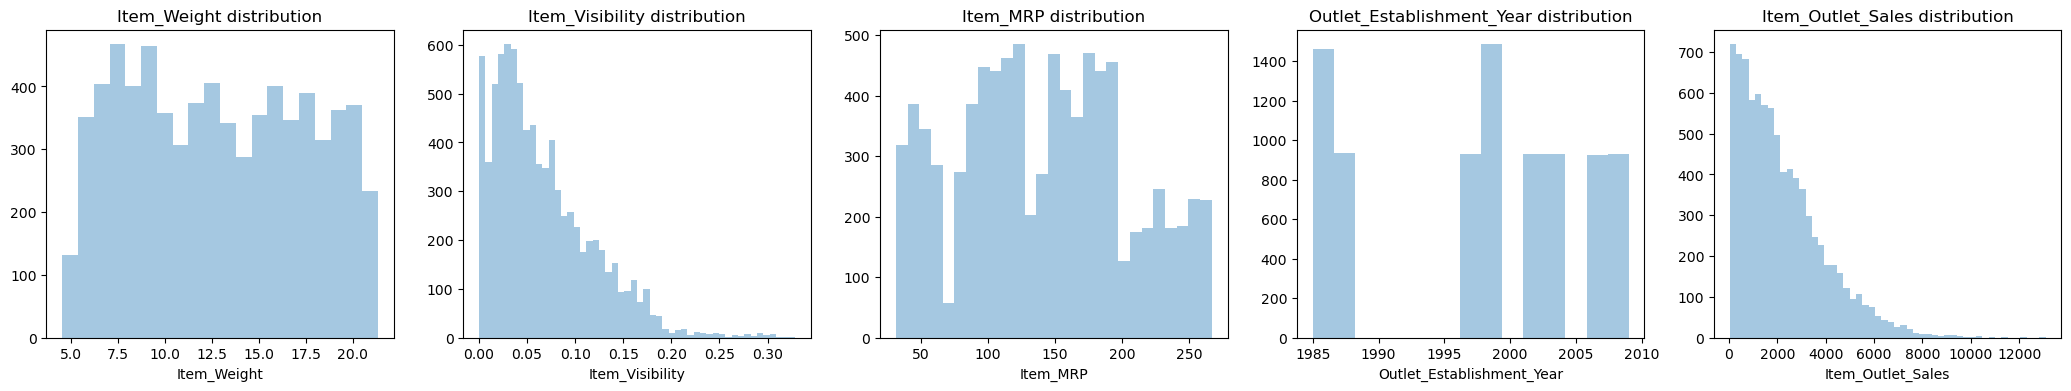

In [659]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_cols):
    sns.distplot(train[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

**Observations:**
- We observe that the item weight range from 5 Kg to 20 Kg.
- Item_Visibility feature is right skewed.
- There are more products in the range of 100 MRP - 180 MRP in the Item_MRP feature
- We can observe that a lots of stores have been established in the years 1985, 1998 etc... and there was no store establishment between 1990 and 1995.
- Item_Outlet_Sales feature is right skewed. We can may be try to do a transformation in order to obtain a normal ou Gaussian distribution

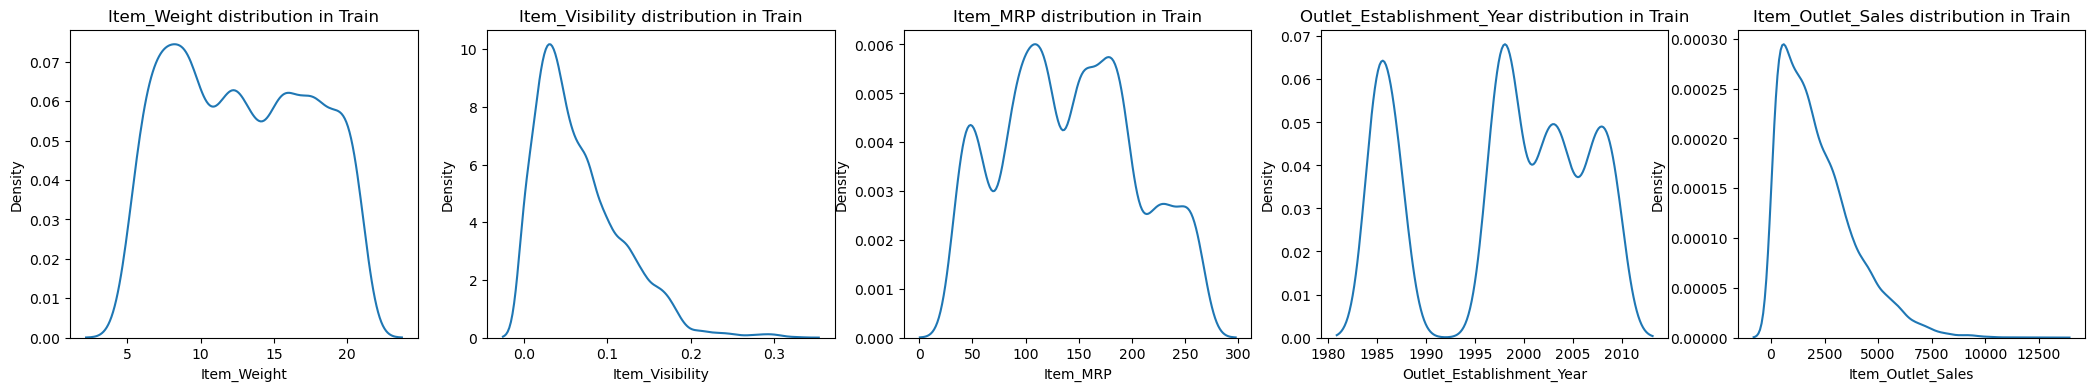

In [660]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26, 4))

for index, col in enumerate(numeric_cols):
    sns.kdeplot(data=train, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

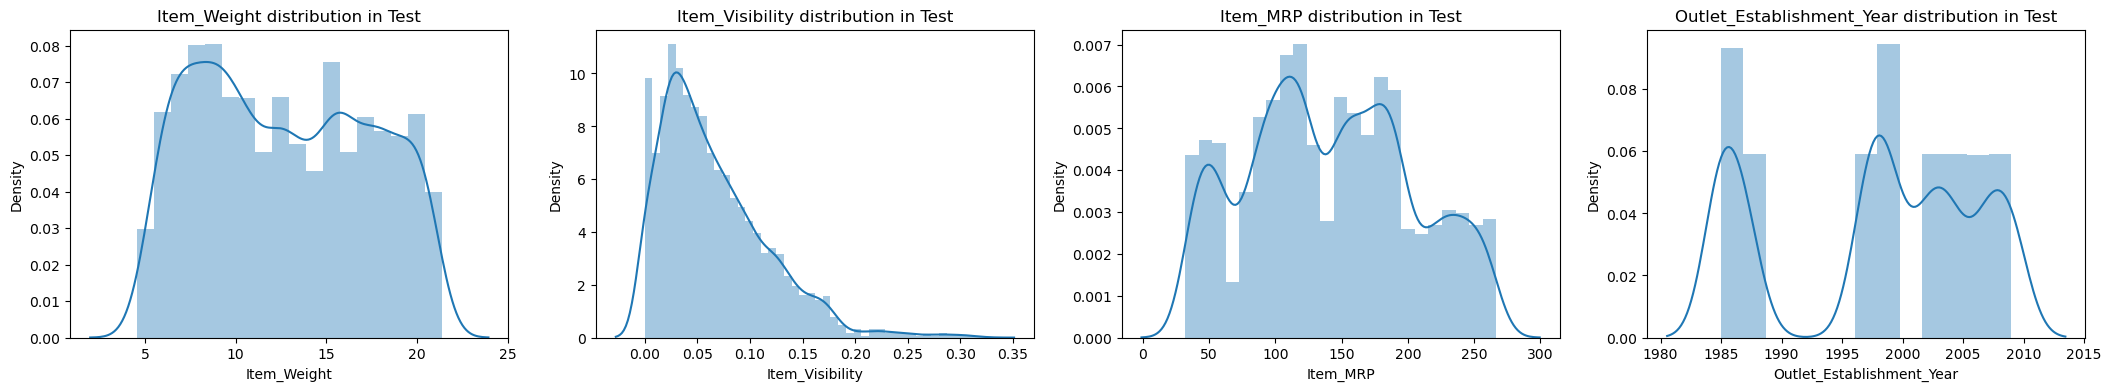

In [661]:
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']):
    sns.distplot(test[col], kde=True, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test')

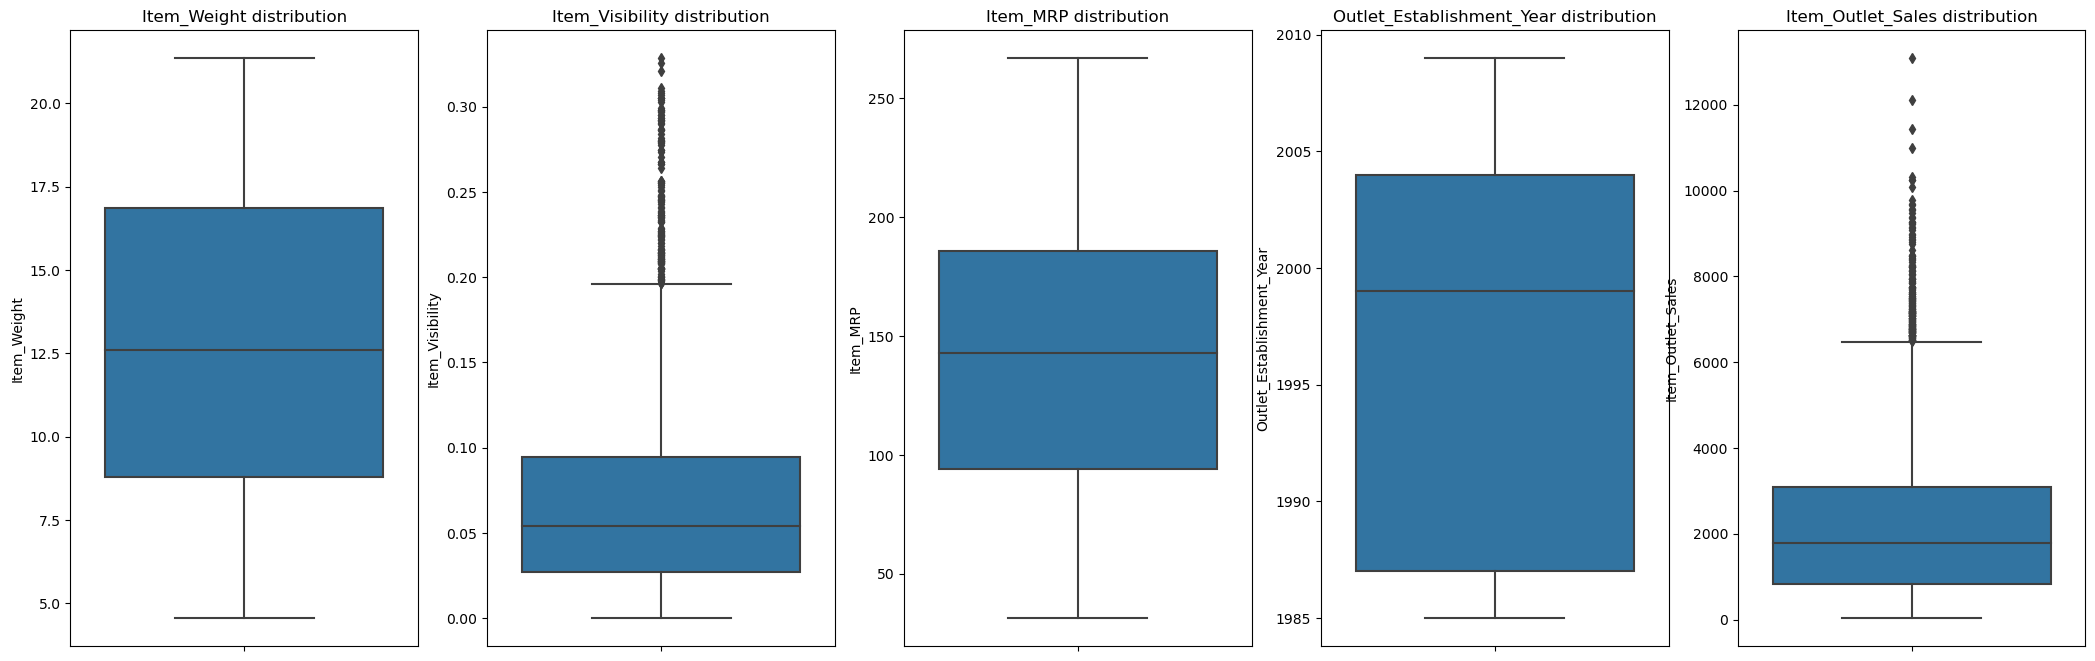

In [662]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numeric_cols):
    sns.boxplot(data=train, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

**Observations:**
- There are almost no outliers in the Item_Weight, Item_MRP and Outlet_Establishment_Year features.
- Conversely there are some **outliers to be removed in the Item_Visibility and Item_Outlet_Sales features.**
- The train and the test data have almost the same distributions

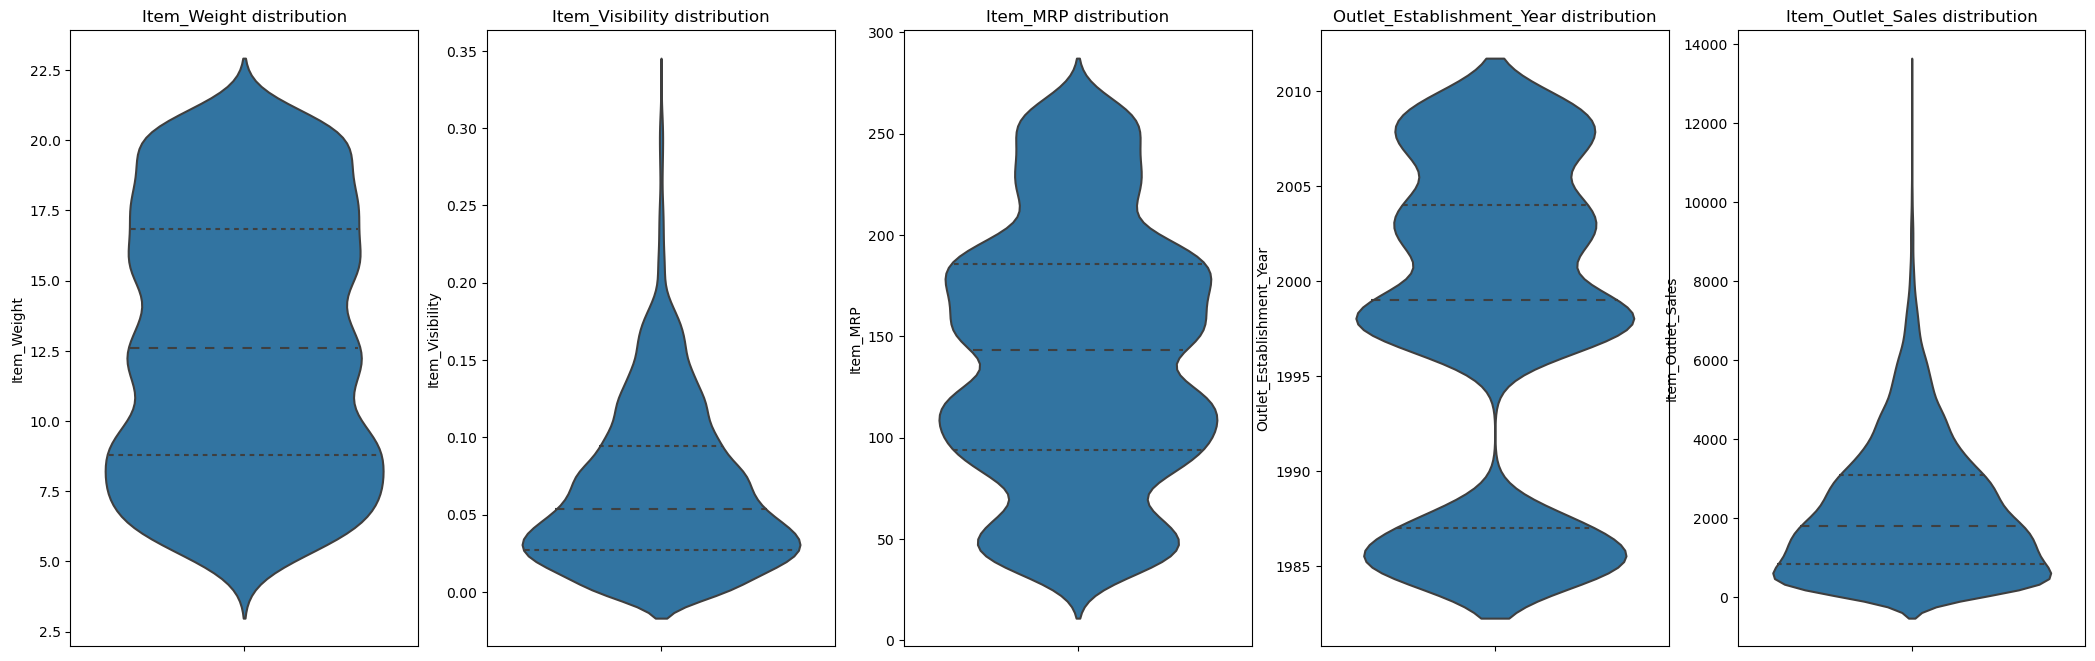

In [663]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(26,8))
for index, col in enumerate(numeric_cols):
    sns.violinplot(data=train, y=col, ax=ax[index], inner='quartile')
    ax[index].set_title(f'{col} distribution')

These graphs confirm the above observations about outliers in **Item_Visibility and Item_Outlet_Sales features.**

### 6.1. Categorical columns

In [664]:
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [665]:
categorical_cols_to_display = [ 
                                 'Item_Fat_Content',
                                 'Item_Type',
                                 'Outlet_Size',
                                 'Outlet_Location_Type',
                                 'Outlet_Type'
                                ]
for col in categorical_cols_to_display:
    print(f"Number of values in the {col} column is:\n{train[col].value_counts() }")
    print("--" * 30)

Number of values in the Item_Fat_Content column is:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64
------------------------------

In [666]:
train['Outlet_Location_Type'].unique().tolist()

['Tier 1', 'Tier 3', 'Tier 2']

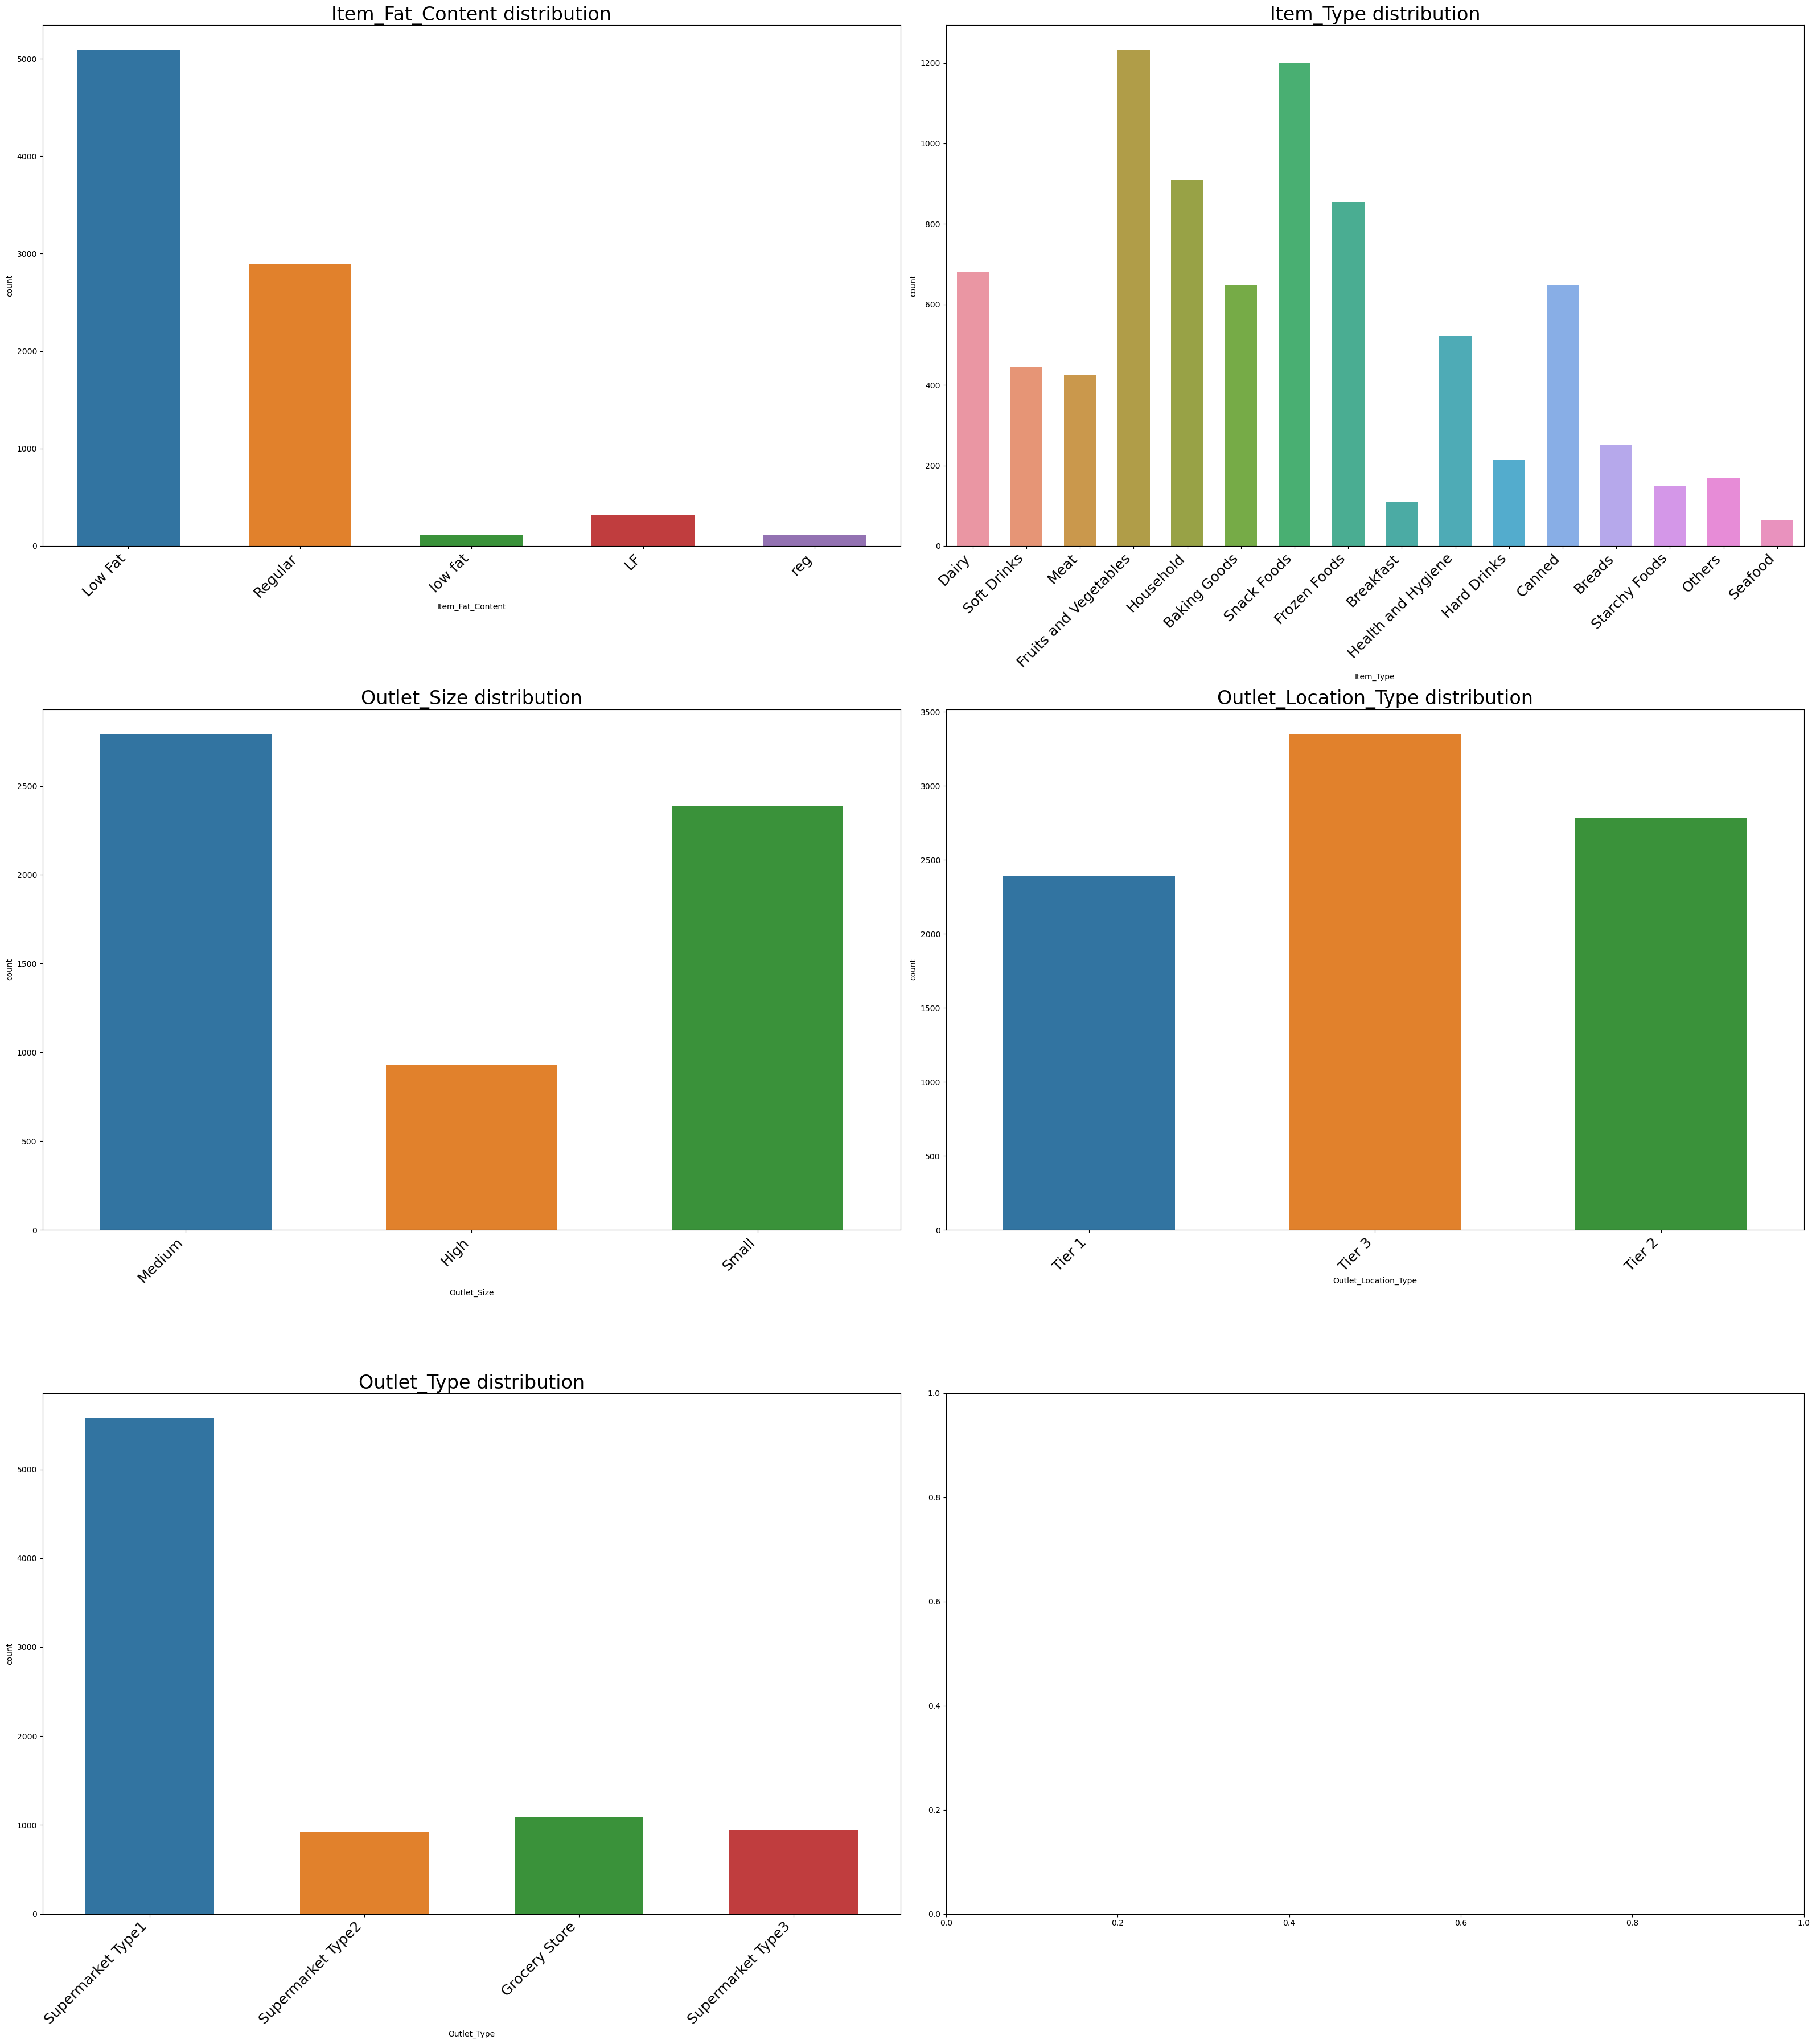

In [667]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=train, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

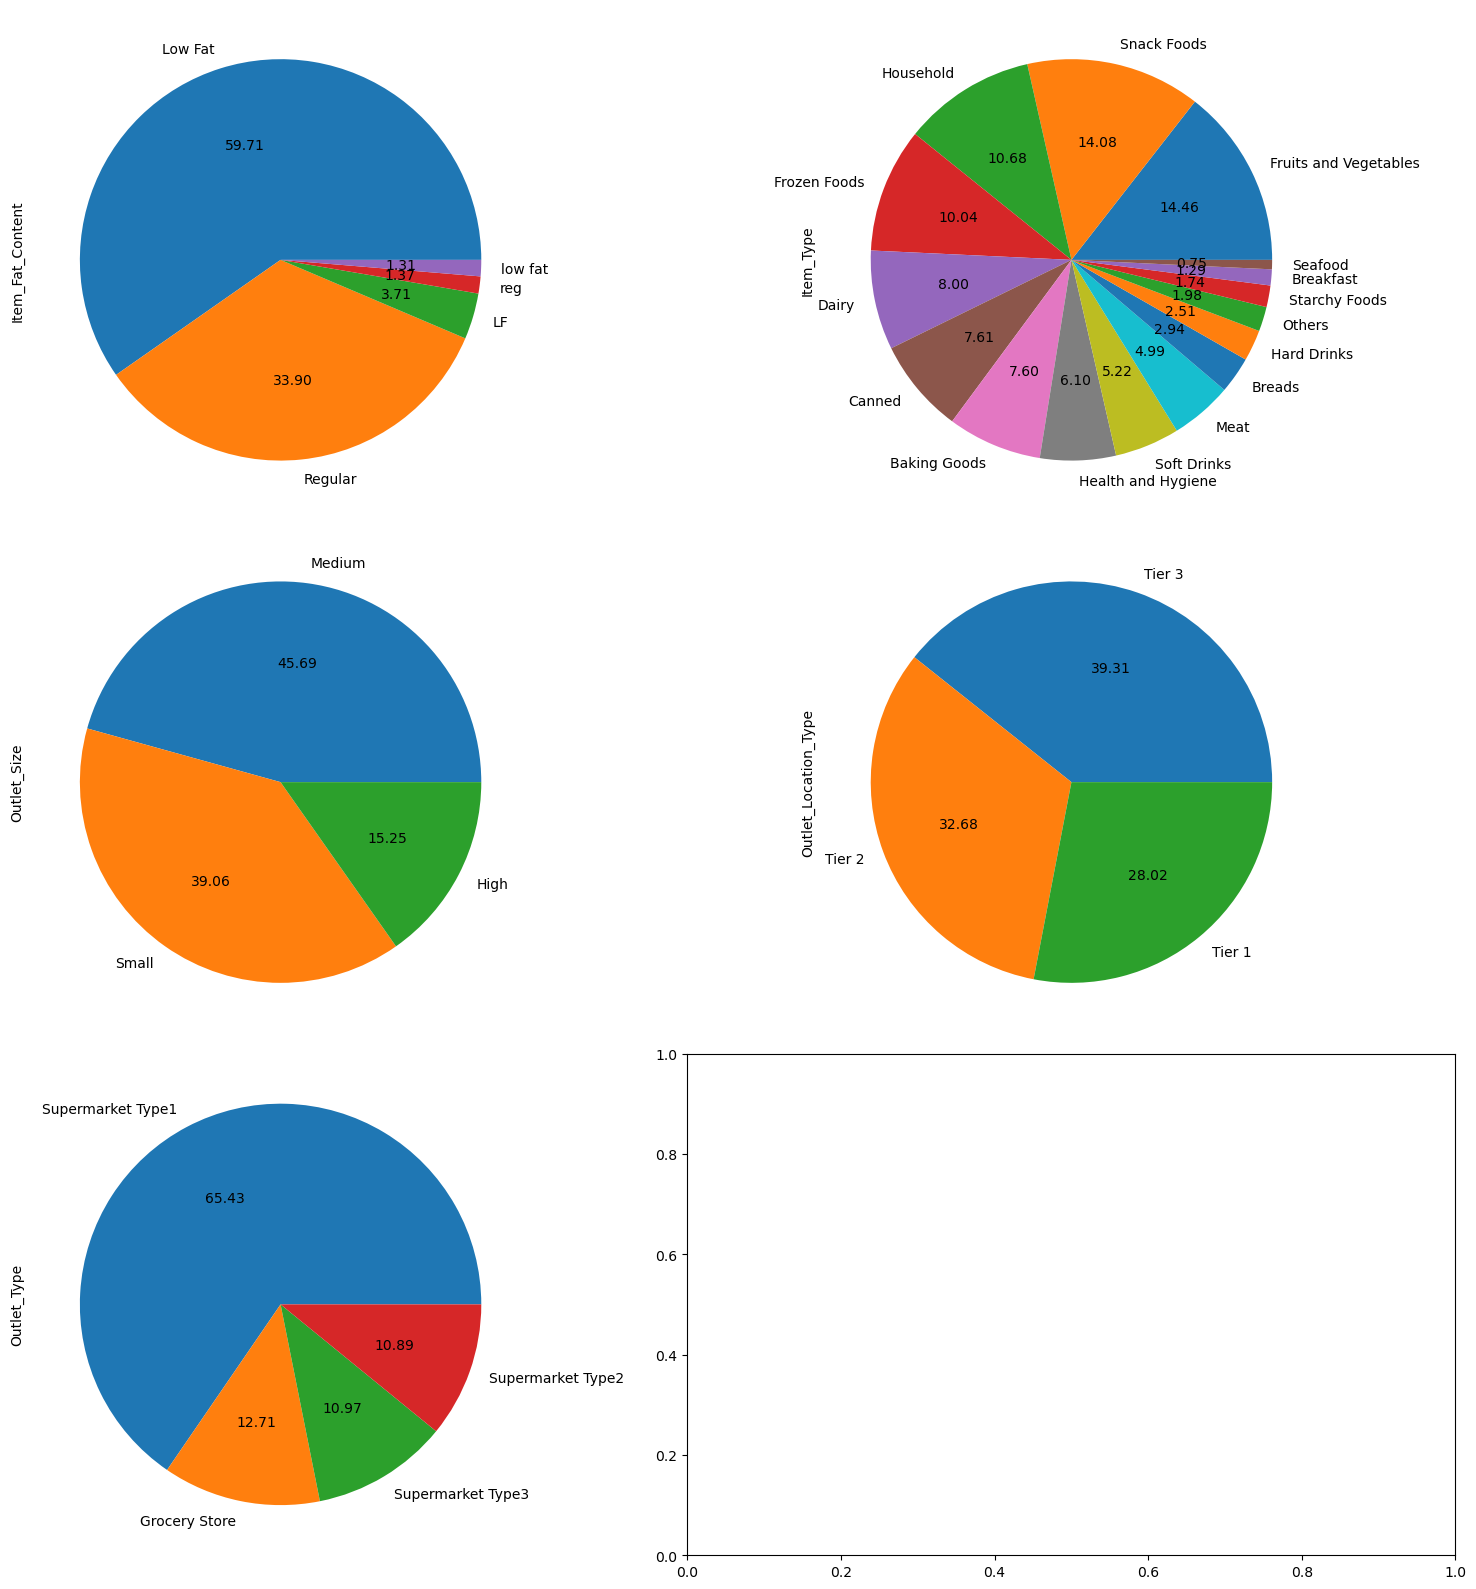

In [668]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    train[col].value_counts().plot(kind="pie", autopct="%.2f", ax=ax[r][c])
    #g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    #ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

**Observations:**
- The Item_Fat_Content column must be cleaned because there are some entry errors:
    * 'Low Fat', 'low fat' and 'LF' should be the same category
    * Similarly 'Regular' and 'reg' should the same
Another remarq in this column is that 'Low Fat' item category is greater than 'Regular' one.

- There are 16 different categories in the the Item_type feature. I think it's a lot. May be in the feature engineering section we can try to group them into categories. For example grouping: 
    * 'Soft Drinks' and 'Hard Drinks' into a 'Drinks' category or
    * 'Snack Foods', 'Frozen Foods', 'Snarchy Foods' and 'Seafood' into a 'Foods' category.
    
- To encode the Outlet_Location_Type feature, we just have to extract the last character i.e:
    * 'Tier 1' ---> 1
    * 'Tier 2' ---> 2
    * 'Tier 3' ---> 3

## 7) Bivariate Analysis

### 7.1. Numerical-Numerical

In [669]:
target = "Item_Outlet_Sales"

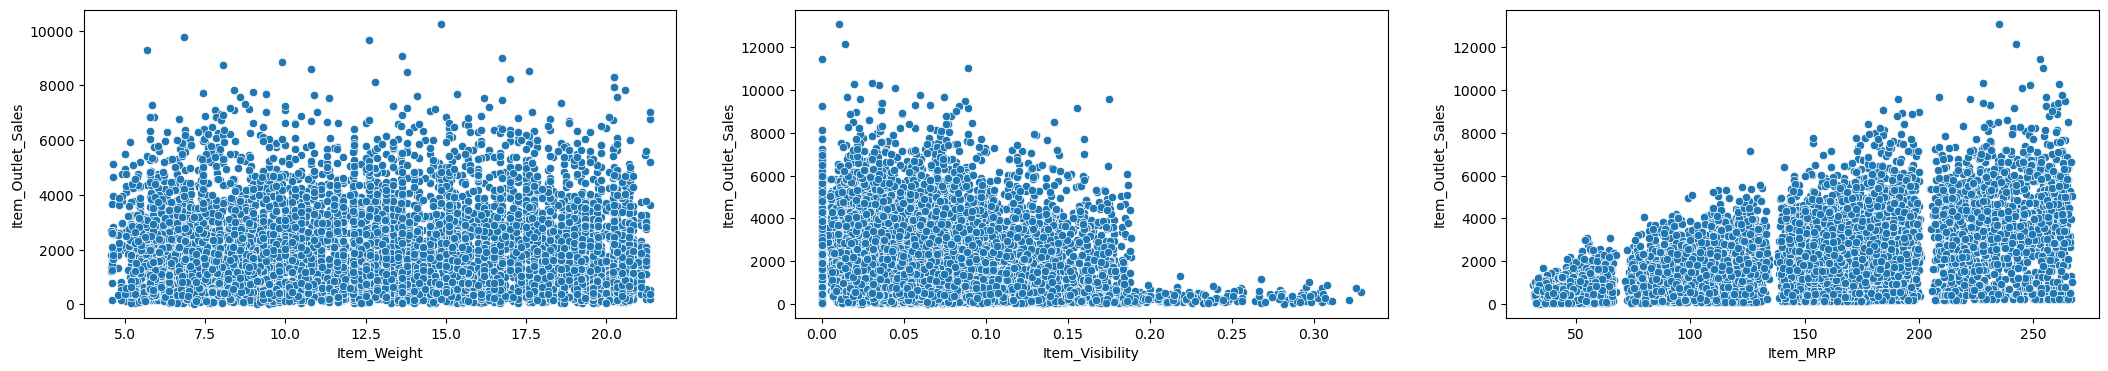

In [670]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train,x=col, y=target, ax=ax[index])
    #ax[index].set_title(f'{col} distribution')

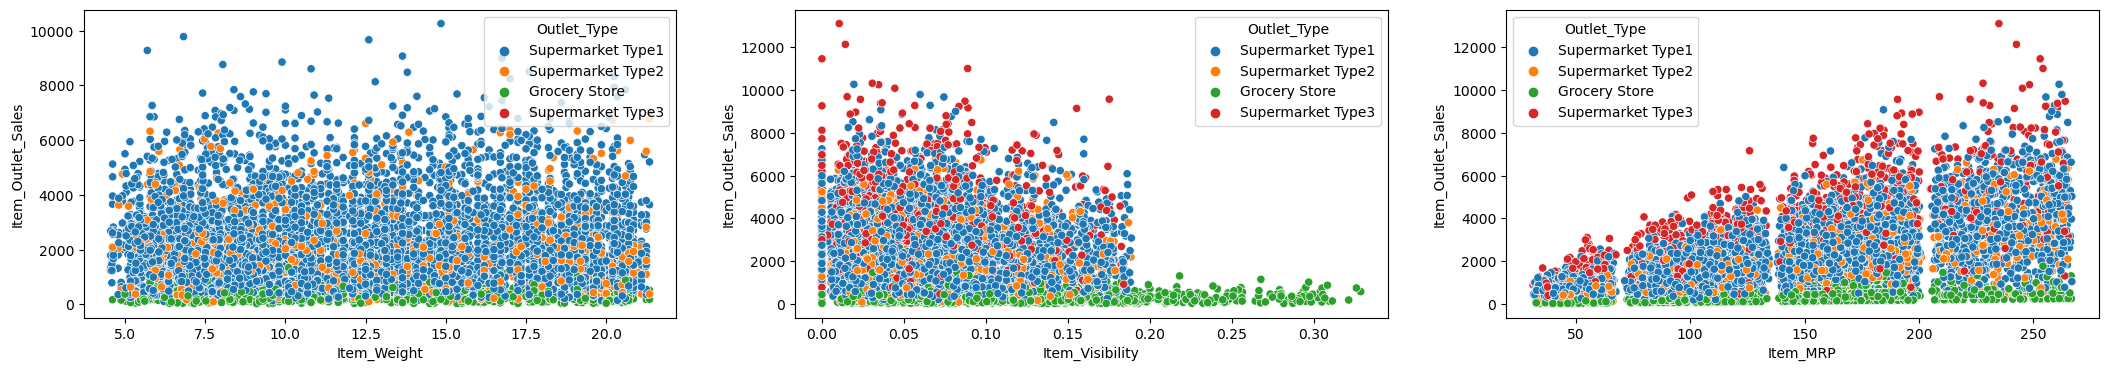

In [671]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train,x=col, y=target, ax=ax[index], hue='Outlet_Type')

<Axes: >

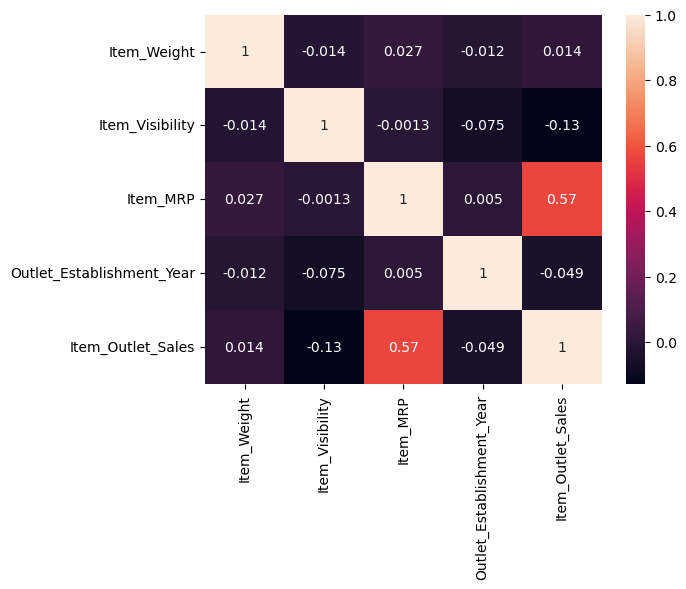

In [672]:
sns.heatmap(train.corr(), annot=True)

### 7.2. Numerical-Categorical

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

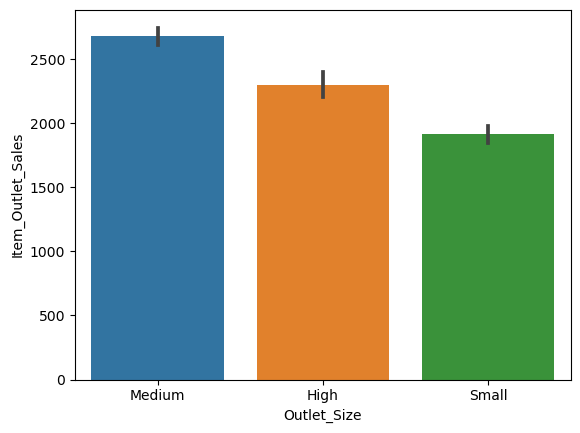

In [673]:
sns.barplot(data=train, x='Outlet_Size', y=target)

In [674]:
train.Outlet_Establishment_Year

0       1999
1       2009
2       1999
3       1998
4       1987
        ... 
8518    1987
8519    2002
8520    2004
8521    2009
8522    1997
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

# 8) Missing Value Treatment

In [675]:
# We cannot use KNN Imputer since the there are still categorical values in the data
"""imputer = KNNImputer(n_neighbors=5)
train = pd.DataFrame(imputer.fit_transform(train),columns = train.columns)"""

'imputer = KNNImputer(n_neighbors=5)\ntrain = pd.DataFrame(imputer.fit_transform(train),columns = train.columns)'

- **OutLet_Size** is a catogerial column, we can use the **mode** to fill the missing values.
- **Item_weight** is a numeric column and after visualizations, we can see clearly that there are no outliers in this feature. So we can replace missing values with its **mean**.

In [676]:
#filling the object values with mode and float type with mean

# for train
train['Outlet_Size'] = train.Outlet_Size.fillna(train.Outlet_Size.dropna().mode()[0]) #replace by the median after
train['Item_Weight'] = train.Item_Weight.fillna(train.Item_Weight.mean())

# for test
test['Outlet_Size'] = test.Outlet_Size.fillna(test.Outlet_Size.dropna().mode()[0]) #replace by the median after
test['Item_Weight'] = test.Item_Weight.fillna(test.Item_Weight.mean())

In [677]:
# get the number of missing datapoints per column
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# 9) Feature Engineering

Upper limit:  0.195979015
Lower limit:  -0.07440424500000001


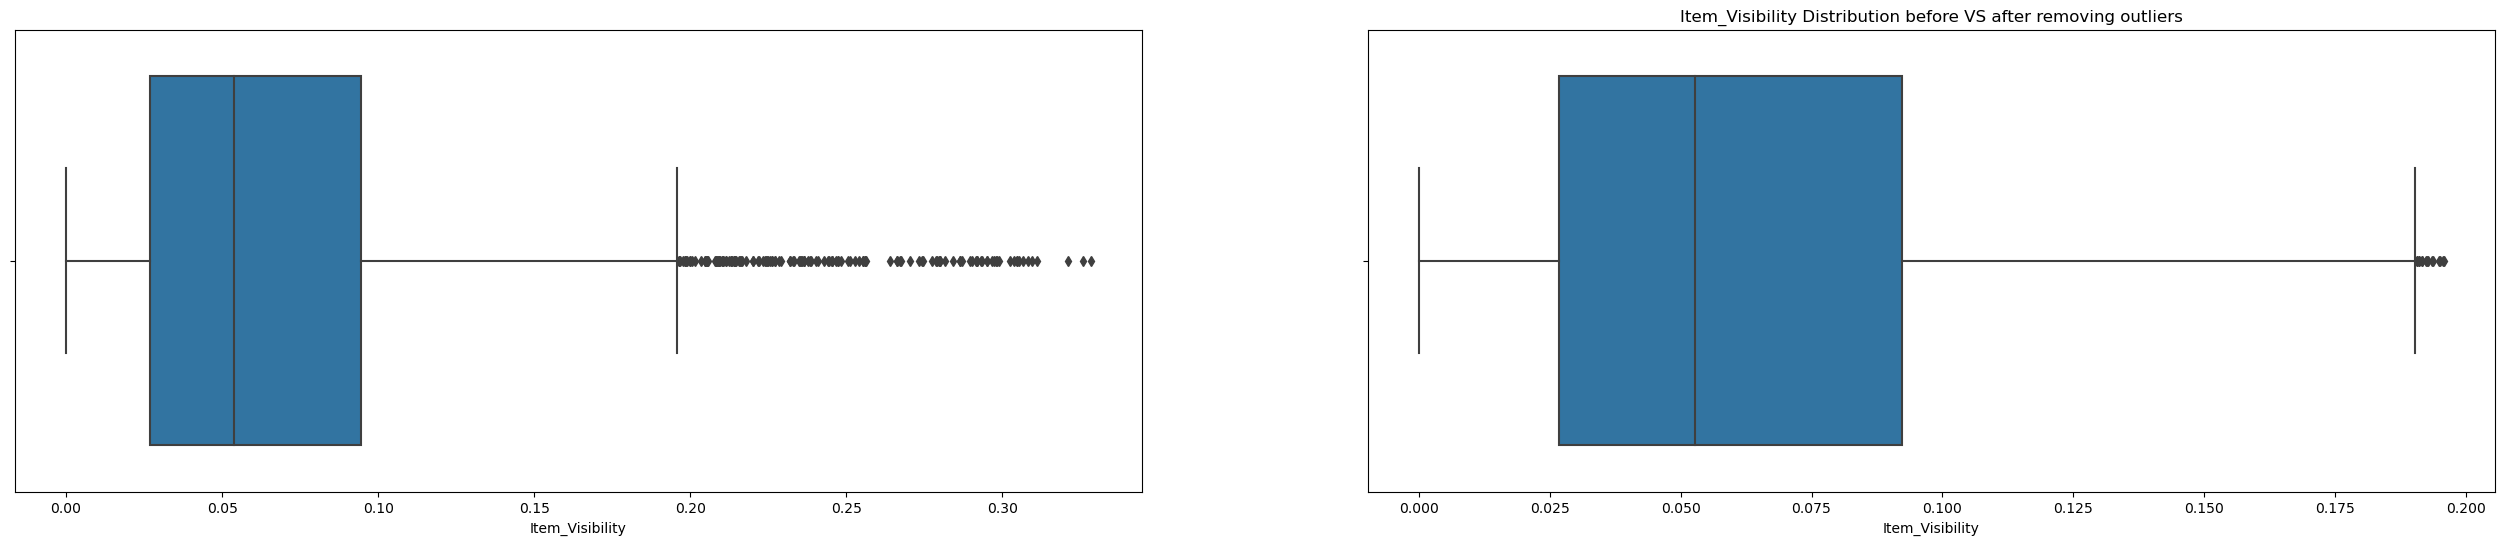

In [678]:
# function to detect outliers using the IQR method

def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(train, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Visibility'], ax=ax[0])

# removing outliers using the above function
train = train[(train['Item_Visibility'] > lower) & (train['Item_Visibility'] < upper)] #train
test = test[(test['Item_Visibility'] > lower) & (test['Item_Visibility'] < upper)]     #test

sns.boxplot(x=train['Item_Visibility'], ax=ax[1])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6499.2067
Lower limit:  -2499.7460999999994


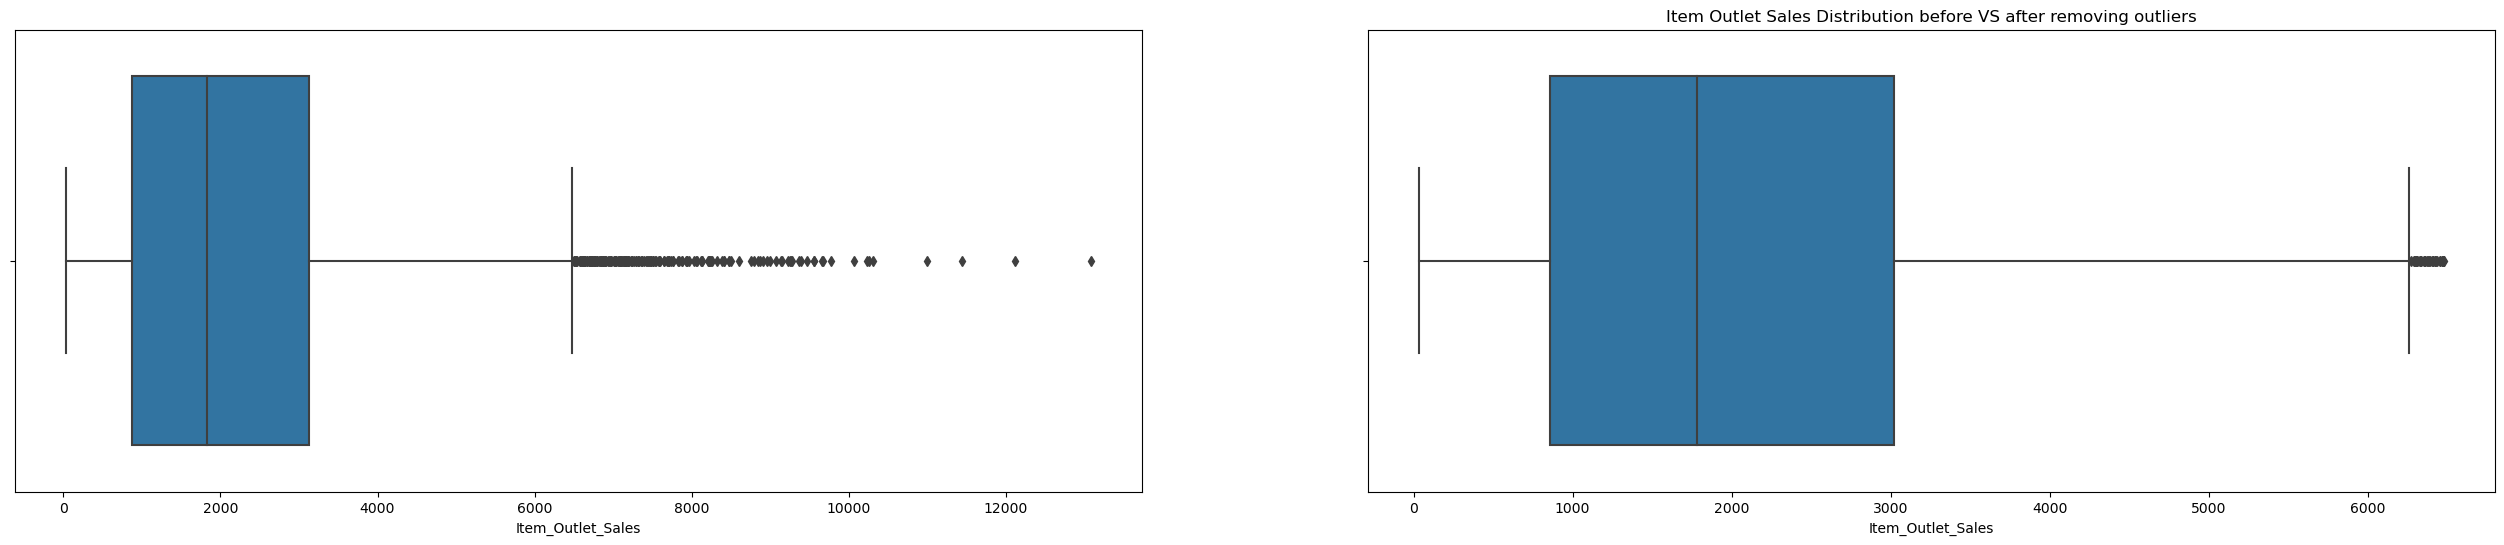

In [679]:
# detect outliers in the Item_Outlet_Sales feature
upper, lower = detect_outliers(train, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[0])

# removing outliers using the same function
train = train[(train['Item_Outlet_Sales'] > lower) & (train['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

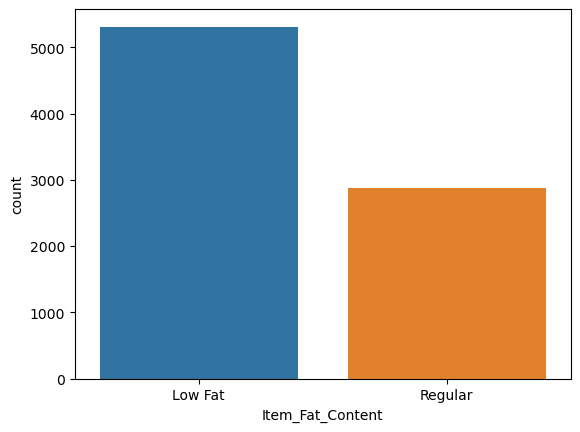

In [680]:
# Let's correct the errors in the Item_Fat_Content column

train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'Low Fat' :'Low Fat',
                                                           'low fat' :"Low Fat",
                                                           'LF'      :"Low Fat",
                                                           'Regular' :'Regular',
                                                           'reg'     :"Regular"
                                                          })

test['Item_Fat_Content'] = test['Item_Fat_Content'].map({'Low Fat' :'Low Fat',
                                                           'low fat' :"Low Fat",
                                                           'LF'      :"Low Fat",
                                                           'Regular' :'Regular',
                                                           'reg'     :"Regular"
                                                          })

sns.countplot(x=train['Item_Fat_Content']);

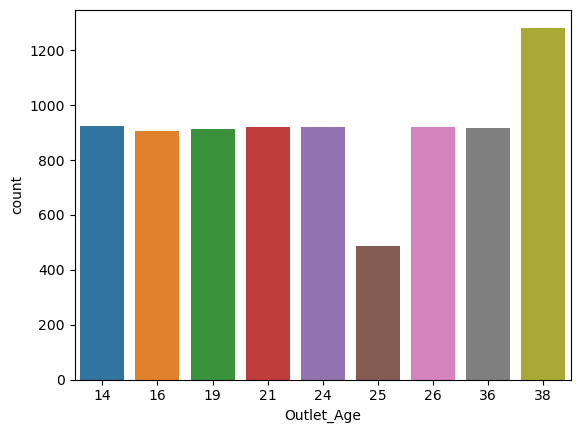

In [681]:
# getting the amount of established years in new column and delete old column
train['Outlet_Age'] = 2023 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2023 - test['Outlet_Establishment_Year']

del train['Outlet_Establishment_Year']
del test['Outlet_Establishment_Year']

sns.countplot(x=train['Outlet_Age']);

# 10) Encoding Categorical Variables

## 11) Label Encoding

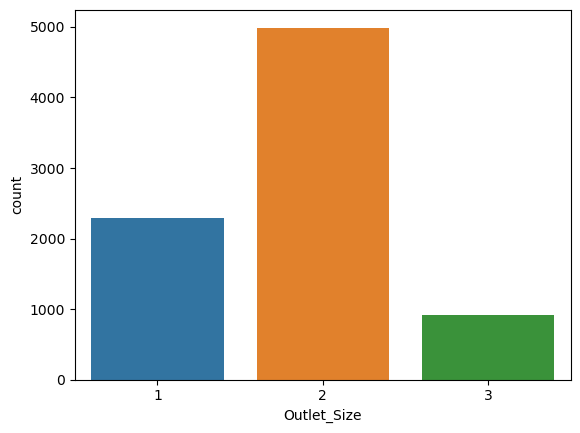

In [682]:
train['Outlet_Size'] = train['Outlet_Size'].map({'Small'  : 1,
                                                 'Medium' : 2,
                                                 'High'   : 3
                                                 }).astype(int)

test['Outlet_Size'] = test['Outlet_Size'].map({'Small'  : 1,
                                               'Medium' : 2,
                                               'High'   : 3
                                              }).astype(int)

sns.countplot(x=train['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

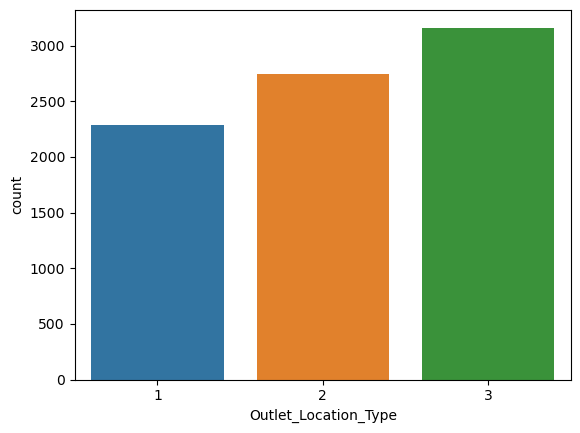

In [683]:
# Outlet_Location_Type feature encoding by getting the last character and converting to int type

train['Outlet_Location_Type'] = train['Outlet_Location_Type'].str[-1:].astype(int)
test['Outlet_Location_Type']  = test['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train['Outlet_Location_Type'])

In the Item_Type feature, there are 16 catgories but when we look closely to Item_Identifier_Categories, it has first two characters defining the item type, these are:
- **FD** for probably **Food**;
- **DR** for probably **Drinks**;
- **NC** for probably **Non-Consumables**. 

**So we'll drop the Item_Identifier feature and create a new column containing these categories.**

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

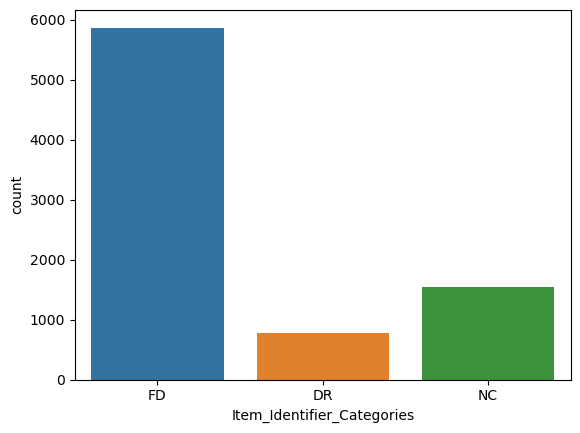

In [684]:
train['Item_Identifier_Categories'] = train['Item_Identifier'].str[0:2] #.astype(int)
test['Item_Identifier_Categories']  = test['Item_Identifier'].str[0:2]

sns.countplot(x=train['Item_Identifier_Categories'])

In [685]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,2,1,Supermarket Type1,3735.1380,24,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,3,Supermarket Type2,443.4228,14,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,2,1,Supermarket Type1,2097.2700,24,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,2,3,Grocery Store,732.3800,25,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,3,3,Supermarket Type1,994.7052,36,NC


In [686]:
#Label Encoder for Ordinate Data

encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ordinal_features:
    train[feature] = encoder.fit_transform(train[feature])
    test[feature]  = encoder.fit_transform(test[feature])

train.shape

(8193, 13)

In [687]:
test.shape

(5570, 12)

In [688]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,2,0,1,3735.1380,24,FD
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2,2,2,443.4228,14,DR
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,2,0,1,2097.2700,24,FD
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,2,2,0,732.3800,25,FD
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,3,2,1,994.7052,36,NC


## 12) One Hot Encoding

In [689]:
# One Hot Encoding for 'Item_Type' variable

train = pd.get_dummies(train, columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)
test  = pd.get_dummies(test,  columns=['Item_Type', 'Item_Identifier_Categories', 'Outlet_Identifier'], drop_first=True)

In [690]:
train.head()
train.shape

(8193, 36)

## 13) PreProcessing Data

In [691]:
# Let's drop useless columns
train.drop(labels=['Item_Identifier'], axis=1, inplace=True)
test.drop(labels=['Item_Identifier'],  axis=1, inplace=True)

In [692]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

In [693]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,...,Item_Identifier_Categories_NC,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,2,0,1,24,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.92,1,0.019278,48.2692,2,2,2,14,0,0,...,0,0,0,1,0,0,0,0,0,0
2,17.50,0,0.016760,141.6180,2,0,1,24,0,0,...,0,0,0,0,0,0,0,0,0,1
3,19.20,1,0.000000,182.0950,2,2,0,25,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.93,0,0.000000,53.8614,3,2,1,36,0,0,...,1,1,0,0,0,0,0,0,0,0


In [694]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [695]:
# splitting into training set and test set 80%-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 14) Modeling

## 15) Linear Regression

In [696]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [697]:
# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(X_test)

In [698]:
print('Training score  : {}'.format(lin_reg_model.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(X_test, y_test)))

Training score  : 0.5516657749034781
Test score      : 0.5471728591811283


In [699]:
# Evaluation
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE  \t         ----> {}'.format(lin_reg_rmse))
print('R2 Score         ----> {}'.format(lin_reg_r2))

RMSE  	         ----> 1021.5214420862889
R2 Score         ----> 0.5471728591811283


The LinearRegression model above give us a training accuracy and a test accuracy of about 55%. We also get an RMSE of about 1021.52 and a R2 score of 0.54.  
Let's try to add some polynomial features to see how good the Linear Regression performs. However, something else we would like to do is standardize our data. This scales our data down to a range between 0 and 1. This serves the purpose of letting us work with reasonable numbers when we raise to a power.

In [700]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(X_test, y_test)))

Training score  : 0.5998162915684562
Test score      : 0.5664183006299102


We got a better Training score of about 0.5998 but the Test score is 0.56 which means that the models start to overfit the data. If we increase the degree of PolynomialFeatures it will get worse.

## 16) Regularized Linear Regression

### 16.1. Ridge Regression or l2 Regularization

To understand Ridge Regression, we need to remind ourselves of what happens during gradient descent, when our model coefficients are trained. During training, our initial weights are updated according to a gradient update rule using a learning rate and a gradient. Ridge regression adds a penalty to the update, and as a result shrinks the size of our weights. This is implemented in scikit-learn as a class called Ridge.  
We will specify our regularization strength by passing in a parameter, alpha. **The larger the value of alpha, the less variance your model will exhibit.**

In [701]:
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Ridge(alpha=7, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Training Score  : 0.5998213122987628
Test Score      : 0.5662904189776015


In [702]:
# Predictions for Ridge on the test data
ridge_predictions = ridge_pipeline.predict(X_test)

In [703]:
# Evaluation
ridge_mse  = mean_squared_error(y_test , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_test, ridge_predictions)

print('Ridge RMSE  \t         ----> {}'.format(ridge_rmse))
print('Ridge R2 Score         ----> {}'.format(ridge_r2))

Ridge RMSE  	         ----> 999.7255019674704
Ridge R2 Score         ----> 0.5662904189776015


### 16.2. Lasso Regression or l1 Regularization

By creating a polynomial model, we created additional features. The question we need to ask ourselves is which of our features are relevant to our model, and which are not.

l1 regularization tries to answer this question by driving the values of certain coefficients down to 0. This eliminates the least important features in our model. We will create a pipeline similar to the one above, but using Lasso. You can play around with the value of alpha, which can range from 0.1 to 1.

In [704]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.1, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.5998128705264035
Test score      : 0.5665343067247388


In [705]:
# Predictions for Lasso on the testset
lasso_predictions = lasso_pipeline.predict(X_test)

In [706]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Lasso RMSE  	         ----> 999.4443748058205
Lasso R2 Score         ----> 0.5665343067247388


Ridge and Lasso gives better results than LinearRegression.

## 17) RandomForest

In [707]:
rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [708]:
# Predictions for XGBoost on the test data
rand_forest_predictions = rand_forest_model.predict(X_test)

In [709]:
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))

Training score  : 0.9347666660356954
Test score      : 0.520517954771466


In [710]:
# Evaluation
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t       ----> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score       ----> {}'.format(rand_forest_r2))

RandomForest RMSE  	       ----> 1051.1566378236232
RandomForest R2 Score       ----> 0.520517954771466


The gap between the training score and the test score is huge so RandomForest is overfitting the data. We can handle this issue with hyperparameter tuning.

## 18. XGBoost

In [711]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [712]:
# Predictions for XGBoost on the test data
xgb_predictions = xgb_model.predict(X_test)

In [713]:
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

XGBoost Training score  : 0.8401175693704412
XGBoost Test score      : 0.4930710324916614


XGBoost is also overfitting the data. Let's try to tune the hyperparameters for XGBoost and see how the model performs.

In [714]:
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1080.8235949482953
XGBoost R2 Score   ----> 0.4930710324916614


# Hyperparameters tuning of XGBoost

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, define-by-run style user API.
The code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

**Notes:**
- I used some XGBRegressor hyperparameters from XGBoost official site.
- Also I used early_stopping_rounds to avoid overfitinging of XGBoost

In [717]:
# we'll use optuna for this task

def objective(trial):
    
    param_grid = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param_grid)  
    model.fit(X_train, y_train,verbose=False)
    
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse

In [718]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

best_parameters = study.best_params
best_parameters

[I 2023-08-07 14:57:50,475] A new study created in memory with name: no-name-2a83836b-8728-4b70-bc89-a0d622d6436f
[I 2023-08-07 14:58:41,418] Trial 0 finished with value: 1001.6547920682862 and parameters: {'lambda': 0.03771188430591706, 'alpha': 0.05895032183276369, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.0038800050069532736, 'max_depth': 13, 'min_child_weight': 249}. Best is trial 0 with value: 1001.6547920682862.
[I 2023-08-07 15:00:59,365] Trial 1 finished with value: 1018.9774450618742 and parameters: {'lambda': 1.788310252097539, 'alpha': 0.025747925374616877, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0039729552860490345, 'max_depth': 15, 'min_child_weight': 247}. Best is trial 0 with value: 1001.6547920682862.
[I 2023-08-07 15:02:18,842] Trial 2 finished with value: 1102.4782199089905 and parameters: {'lambda': 0.03522075011017612, 'alpha': 2.3301687031168794, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.0468499767829065

Number of finished trials: 20
Best trial: {'lambda': 0.024642092571772804, 'alpha': 0.429660387797169, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.002091040699753347, 'max_depth': 5, 'min_child_weight': 110}


{'lambda': 0.024642092571772804,
 'alpha': 0.429660387797169,
 'colsample_bytree': 0.6,
 'subsample': 0.6,
 'learning_rate': 0.002091040699753347,
 'max_depth': 5,
 'min_child_weight': 110}

# Final Predictions On The Test Dataset

In [719]:
"""xgb_cv_scores, xgb_r2_scores = list(), list()
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
    
for i, (train_ix, test_ix) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    #======================================================== XGBoost ============================================================#
    
    xgb_final_model = XGBRegressor(objective ='reg:squarederror', **best_parameters).fit( X_train, y_train,
                                                                                    #eval_set = [(X_train, y_train), (X_test, y_test)],
                                                                                    verbose=0
                                                                                         )
    
    # Validation
    xgb_preds = xgb_final_model.predict(X_test)
    
    #RMSE
    xgb_score_fold = mean_squared_error(y_test, xgb_preds, squared=False)    
    xgb_cv_scores.append(xgb_score_fold)
    
    #R2 score
    xgb_r2_score = r2_score(y_test, xgb_preds)
    xgb_r2_scores.append(xgb_r2_score)
    
    print('Fold N°', i, '==> XGBoost -        RMSE: ====>',   xgb_score_fold)
    print('Fold N°', i, '==> XGBoost -        R2 Score: ====>', xgb_r2_score)
    """

Fold N° 0 ==> XGBoost -        RMSE: ====> 2237.9204940249497
Fold N° 0 ==> XGBoost -        R2 Score: ====> -1.1486340234229897
Fold N° 1 ==> XGBoost -        RMSE: ====> 2166.335934192971
Fold N° 1 ==> XGBoost -        R2 Score: ====> -1.1057666596231903
Fold N° 2 ==> XGBoost -        RMSE: ====> 2144.281024746699
Fold N° 2 ==> XGBoost -        R2 Score: ====> -1.0893704086289207
Fold N° 3 ==> XGBoost -        RMSE: ====> 2187.3751583804487
Fold N° 3 ==> XGBoost -        R2 Score: ====> -1.12756740069687
Fold N° 4 ==> XGBoost -        RMSE: ====> 2209.5457853552157
Fold N° 4 ==> XGBoost -        R2 Score: ====> -1.1632849971111616


In [722]:
"""# XGBoost scores
xgb_cv_rmse_score = np.mean(xgb_cv_scores)
xgb_cv_r2_score   = np.mean(xgb_r2_scores)
print(f"CV RMSE on train data                ======> {xgb_cv_rmse_score}")
print(f"CV R2 score on train data            ======> {xgb_cv_r2_score}")"""

# Final predictions on test data using Lasso
final_test_preds = lasso_pipeline.predict(test)

# Saving The Final Model

In [723]:
# Saving model to pickle file
with open("BigMart_Sales_Model.pkl", "wb") as file: # file is a variable for storing the newly created file.
    pickle.dump(lasso_pipeline, file)              # Dump function is used to write the object into the created file in byte format.